In [ ]:
# 目的: 批量處理FC資料庫全部，母果蠅大腦，進行腦區分割，需要分左腦右腦。(已經挑選都有左右的大腦)
# =======================母果蠅專用=======================
# 此檔案負責 0~5000
# 投影2D & YOLO偵測位置都一次全部做完
# 未來從Step5 開始進行即可，只有第一次要跑投影和YOLO偵測
# 0~4999 or 5000~9999 都從Step5 才開始將brain_files 改成[:5000] or [5000:10000]
# 請在Step5 之前設定本次批次範圍
# 未來可以新增在第三階段完成後刪除第二階段資料夾 以此類推在第四階段完成後也刪除第三階段!!!!!!!

# 先將全FC資料庫的母果蠅名稱取出並儲存成npy
import os
import numpy as np
import nibabel as nib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, metrics
import tifffile as tif
import time
from os.path import getsize
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"
src_files = os.listdir(nii_gz_src)
print('nii.gz 總共數量: ',len(src_files))
# 初始化兩個列表，一個用於存放母果蠅的編號，另一個用於存放公果蠅的編號
female_flies = []
male_flies = []

# 遍歷 src_files 列表，根據檔案名稱中的標記分類
for file_name in src_files:
    if '-F-' in file_name:
        female_flies.append(file_name)
    elif '-M-' in file_name:
        male_flies.append(file_name)

# 印出母果蠅和公果蠅的總數量
print(f"母果蠅總數量: {len(female_flies)}")
print(f"公果蠅總數量: {len(male_flies)}")

# 獲取每個資料夾中的檔案名稱並移除副檔名
female_brain_files = [file.split('.')[0] for file in female_flies]
male_brain_files = [file.split('.')[0] for file in male_flies]

# 將 female_flies 和 male_flies 列表儲存為 .npy 檔案
np.save('2024_全FC資料庫的_female_brain_files.npy', female_brain_files)
np.save('2024_全FC資料庫的_male_brain_files.npy', male_brain_files)

print("檔案 female_brain_files.npy 和 male_brain_files.npy 已儲存。")

# nii.gz 總共數量:  28573
# 母果蠅總數量: 22835
# 公果蠅總數量: 5738
# 檔案 female_brain_files.npy 和 male_brain_files.npy 已儲存。

DLG_shape:  (119, 1024, 1024)


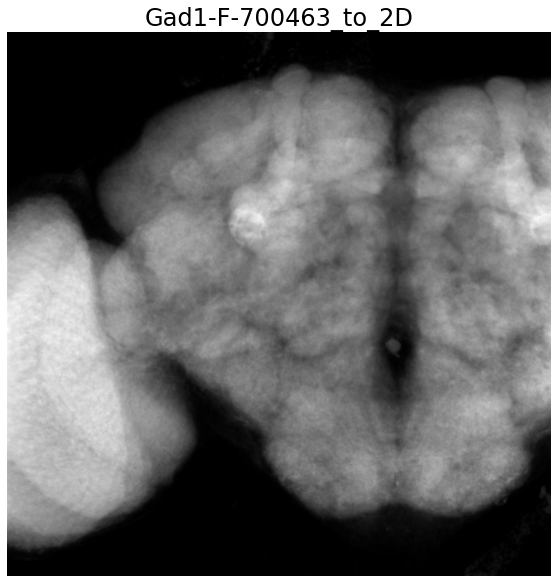

In [1]:
# Step0 導入套件
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure

# 記錄開始時間
start_time = time.time()

# Step1 設定大腦區域和相關變數
seg_target = 'MB'
seg_target_small = 'mb'
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

# Step2 讀取檔案名稱列表
brain_files = np.load("2024_全FC資料庫的_female_brain_files.npy")# ===========先處理母果蠅

# 清空並創建 waiting_for_infer 資料夾
if not os.path.exists('waiting_for_infer'):
    os.mkdir('waiting_for_infer')
else:
    for file in os.listdir('waiting_for_infer'):
        os.remove('waiting_for_infer/' + file)

# Step3 處理第一個大腦3D影像
brain_file = brain_files[0]  # 選取第一個檔案
DLG = np.load(nii_gz_src + brain_file + '.npy')  # 讀取對應的3D影像
DLG = np.transpose(DLG, (2, 1, 0))
print('DLG_shape: ', DLG.shape)

# 投影成2D圖
projection = np.sum(DLG, axis=0)  # 取加總值
# 顯示2D圖像
plt.figure(figsize=(10, 10))
plt.imshow(projection, cmap='gray')
plt.title(brain_file + '_to_2D', fontsize=24)
plt.axis('off')
plt.show()

# # Step4 將2D圖片輸出至 waiting_for_infer
# projection = projection / np.max(projection) * 255
# im = Image.fromarray(projection.astype('uint8'))  # 要將float32 改成uint8
# im.save('waiting_for_infer/' + brain_file + '.png')


In [2]:
# ==========================設定所有會儲存使用的路徑==========================
# 設定NAS路徑: /mnt/nas_1/LoLab/kaiyi_hsu/LYNSU # 這個通常不會動
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'
# 定義 輸入給yolo的2D圖片資料夾路徑
waiting_for_infer = 'waiting_for_infer_female'

# 定義第一階段輸出資料夾
Step1_output_path = nas_path+'使用者程序_第一階段存檔內容_YOLO提取DLG_母果蠅_0_1000'

# 定義第二階段輸出資料夾
Step2_output_path = nas_path+'使用者程序_第二階段存檔內容_完成滑動切割_母果蠅_0_1000'

# 定義第三階段輸出資料夾
Step3_output_path = nas_path+'使用者程序_第三階段存檔內容_完成推理_母果蠅_0_1000'

# 定義第四階段輸出資料夾
Step4_output_path = nas_path+'使用者程序_第四階段存檔內容_完成還原Z拓展後尺寸_母果蠅_0_1000'

# 定義第五階段輸出資料夾
Step5_output_path = nas_path+'使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅_0_1000'

# 定義 original_info 儲存名稱
original_info_name = 'original_info_母果蠅_0_1000'

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc  # 引入垃圾回收模組
from patchify import patchify, unpatchify
%matplotlib inline
# Step1 設定大腦區域和相關變數
seg_target = 'MB'
seg_target_small = 'mb'
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

# Step0 導入套件 ======IO太緩慢
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc  # 引入垃圾回收模組
from patchify import patchify, unpatchify
%matplotlib inline

# 記錄開始時間
start_time = time.time()

# Step1 設定大腦區域和相關變數
seg_target = 'MB'
seg_target_small = 'mb'
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

# Step2 讀取檔案名稱列表
brain_files = np.load("2024_全FC資料庫的_female_brain_files.npy")# ===========先處理母果蠅
brain_files.sort()

# =============================測試先只用100個
# 這裡先將全部母果蠅腦全部投影成2D
brain_files = brain_files[:200]


# 清空並創建 waiting_for_infer 資料夾
if not os.path.exists(waiting_for_infer):
    os.mkdir(waiting_for_infer)
else:
    for file in os.listdir(waiting_for_infer):
        os.remove(waiting_for_infer+'/' + file)

# Step3 批量處理所有大腦3D影像
for brain_file in brain_files:
    DLG = np.load(nii_gz_src + brain_file + '.npy')  # 讀取對應的3D影像
    DLG = np.transpose(DLG, (2, 1, 0))  # 調整維度順序
#     print('Processing:', brain_file, 'Shape:', DLG.shape)

    # 投影成2D圖
    projection = np.sum(DLG, axis=0)  # 取加總值

    # 將2D圖片輸出至 waiting_for_infer
    projection = projection / np.max(projection) * 255
    im = Image.fromarray(projection.astype('uint8'))  # 轉換成uint8格式
    im.save(waiting_for_infer+'/' + brain_file + '.png')

# 記錄結束時間
end_time = time.time()
print("處理完成，總耗時:", end_time - start_time, "秒")



# =========================平行化加速 使用8個cpu運行====只跑一次

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc  # 引入垃圾回收模組
from patchify import patchify, unpatchify
%matplotlib inline

# 記錄開始時間
start_time = time.time()

# Step1 設定大腦區域和相關變數
seg_target = 'MB'
seg_target_small = 'mb'
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

# Step2 讀取檔案名稱列表
brain_files = np.load("2024_全FC資料庫的_female_brain_files.npy")# ===========先處理母果蠅
brain_files.sort()

# =============================測試先只用100個
# 這裡先將全部母果蠅腦全部投影成2D
# brain_files = brain_files[:200]

from concurrent.futures import ThreadPoolExecutor
# 清空並創建 waiting_for_infer 資料夾
if not os.path.exists(waiting_for_infer):
    os.mkdir(waiting_for_infer)
else:
    for file in os.listdir(waiting_for_infer):
        os.remove(waiting_for_infer+'/' + file)
def process_and_save_image(brain_file):
    DLG = np.load(nii_gz_src + brain_file + '.npy')  # 加载3D图像
    DLG = np.transpose(DLG, (2, 1, 0))  # 调整维度顺序
    projection = np.sum(DLG, axis=0)  # 生成2D投影
    projection = projection / np.max(projection) * 255  # 调整亮度
    im = Image.fromarray(projection.astype('uint8'))
    im.save(waiting_for_infer + '/' + brain_file + '.png')

start_time = time.time()

# 使用ThreadPoolExecutor来加速处理
with ThreadPoolExecutor(max_workers=8) as executor:  # 可以根据您的系统调整max_workers的数量
    executor.map(process_and_save_image, brain_files)

end_time = time.time()
print("处理完成，总耗时:", end_time - start_time, "秒")


# Step4 使用YOLOv7 對 XY view進行預測 seg_target 特徵框========只跑一次
# 輸出的推理結果在: seg_target_small + _inference/detect 資料夾
DLG_src_files = os.listdir(waiting_for_infer)
print('等待推理的圖片數量: ', len(DLG_src_files))

# 清理舊的推理輸出資料夾
os.system('rm -r ' + seg_target_small + '_inference/user')

source_path = waiting_for_infer


# 調整信心度閾值和顏色設定
# GT顏色 = #FFC000 在 BGR 表示法中是 (0, 192, 255)
# MB顏色 = #00B0F0 在 BGR 表示法中是 (240, 176, 0)
# AL顏色 = #FF0000 在 BGR 表示法中是 (0, 0, 255)

# 調整信心度閾值並執行 YOLO 推理
# 注意：未來若要偵測其他腦區需要換 weights，並可能需要手動改 al_inference
start_time_YOLO = time.time()  # 記錄開始時間
os.system(f'python detect.py --conf-thres 0.4 --color 240 176 0 '
          f'--weights ./mb_trained/train/exp/weights/best.pt '
          f'--source {source_path} --img-size 640 --save-txt '
          f'--project {seg_target_small}_inference/user > /dev/null 2>&1')
end_time_YOLO = time.time()  # 記錄結束時間
# ==================因為添加  > /dev/null 2>&1 可以讓文字輸出消失==================
# 輸出推理時間
print("YOLO 推理完成，總耗時: {:.2f} 秒".format(end_time_YOLO - start_time_YOLO))

In [15]:
# 檢查YOLO輸出的圖片和 waiting_for_infer_female 資料夾內的檔案差異
waiting_for_infer_files = os.listdir('waiting_for_infer_female')
after_yolo_file = os.listdir('mb_inference/user/exp/')

In [14]:
waiting_for_infer_files[0]

'Cha-F-100313.png'

In [17]:
len(waiting_for_infer_files)

22835

In [16]:
len(after_yolo_file)

22836

In [ ]:
# =============== 已經完成YOLO偵測目標腦區範圍，可以人工檢查 ===============
# ==============第二步階段: 將目標腦區的範圍進行提取、滑動切割===============

In [3]:
# ========================2024/02/17 批量處理特定範圍 0~4999 or 5000~10000========================
# 重新讀取全部母果蠅的名稱
brain_files = np.load("2024_全FC資料庫的_female_brain_files.npy")# ===========先處理母果蠅
brain_files.sort()

# ============================= 這裡設定0~5000=============================
brain_files = brain_files[:1000]

In [ ]:
# Step5 批量讀取 特別大腦DLG樣本 資料夾內的大腦，並提取範圍內3D影像，再加以拓展進行滑動切割立方體輸出。
import os
import numpy as np
import cv2
start_time_crop_resize = time.time()  # 記錄開始時間

def resize_and_pad(whole_brain, x_start, x_end, y_start, y_end, target_size=168, z_min_size=64, step_of_slide=20):
    """
    对特定区域的大脑进行调整大小和填充
    """
    brain_region = [whole_brain[i, y_start:y_end, x_start:x_end] for i in range(len(whole_brain))]
    brain_region = np.array(brain_region)
    
    # 确定需要缩放还是放大
    if brain_region.shape[1] > target_size:
        resized_brain = np.array([cv2.resize(slice, (target_size, target_size), interpolation=cv2.INTER_AREA) for slice in brain_region])
    else:
        resized_brain = np.array([cv2.resize(slice, (target_size, target_size), interpolation=cv2.INTER_CUBIC) for slice in brain_region])

    # 填充 Z 轴以达到最小尺寸
    num_layers_to_add = 0
    while len(resized_brain) < z_min_size or (len(resized_brain) - z_min_size) % step_of_slide != 0:
        resized_brain = np.append(resized_brain, np.zeros((1, target_size, target_size)), axis=0)
        num_layers_to_add += 1
    print(f'扩展前层数: {brain_region.shape}')
    return resized_brain, num_layers_to_add

def process_brain_region(seg_target, num_of_yolo_box, x1, x2, y1, y2, whole_brain,max_dim=1023):
    """
    处理大脑区域
    """
    original_info = []
    for box_num in range(1, num_of_yolo_box + 1):
        print(f'处理第 {box_num} 个脑区')
        X_start, X_end = x1[box_num - 1], x2[box_num - 1]
        Y_start, Y_end = y1[box_num - 1], y2[box_num - 1]
        X_length, Y_length = X_end - X_start, Y_end - Y_start

#         # 按需要扩展区域
#         if X_length > Y_length:
#             Y_start -= (X_length - Y_length) // 2
#             Y_end += (X_length - Y_length) - (X_length - Y_length) // 2
#         elif Y_length > X_length:
#             X_start -= (Y_length - X_length) // 2
#             X_end += (Y_length - X_length) - (Y_length - X_length) // 2

        # 按需要扩展区域 ===============================這裡確保 X_start 和 Y_start 不小於 0 &  X_end 和 Y_end 不超過最大維度（在這個例子中是 1023）
        if X_length > Y_length:
            Y_start = max(Y_start - (X_length - Y_length) // 2, 0)
            Y_end = min(Y_end + (X_length - Y_length) - (X_length - Y_length) // 2, max_dim)
        elif Y_length > X_length:
            X_start = max(X_start - (Y_length - X_length) // 2, 0)
            X_end = min(X_end + (Y_length - X_length) - (Y_length - X_length) // 2, max_dim)
        # 调整大小和填充
        resized_brain, num_layers_added = resize_and_pad(whole_brain, X_start, X_end, Y_start, Y_end)
        print(f'额外添加层数: {num_layers_added}')
#         print(f'扩展前层数: {len(resized_brain) - num_layers_added}')
        print(f'扩展后层数: {resized_brain.shape}')

        # 计算未来滑动切割生成的 cubes 数量
        future_cubes = ((resized_brain.shape[0] - 64) / Step_of_slide + 1) * ((resized_brain.shape[1] - Size_of_cube) / Step_of_slide + 1) ** 2
        original_info.append([f'{target_name}_No_{box_num}_DLG', X_start, X_end, Y_start, Y_end, len(resized_brain) - num_layers_added, int(future_cubes)])

        # 保存处理后的大脑区域
        np.save(f'{Step1_output_path}/{target_name}_No_{box_num}_DLG', resized_brain)

    return original_info

# 主程序
original_info = []
Step_of_slide, Size_of_cube = 20, 128
# 清空並創建 使用者程序_第一階段存檔內容_YOLO提取DLG 資料夾
if not os.path.exists(Step1_output_path):
    os.mkdir(Step1_output_path)
else:
    for file in os.listdir(Step1_output_path):
        os.remove(Step1_output_path+'/' + file)

for num, target_name in enumerate(brain_files):
    print(num, target_name)
    DLG = np.load(f"/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/{target_name}.npy")
    DLG = np.transpose(DLG, (2, 1, 0))
    print('DLG_shape: ', DLG.shape)
    WholeBrain_DLG_Amira = DLG.copy()

    # 读取 YOLO 检测结果
    txt_path = os.path.join(seg_target_small + '_inference/user/exp/labels', f'{target_name}.txt')
    try:
        with open(txt_path, 'r') as source_file:
            x1, y1, x2, y2 = [], [], [], []
            for line in source_file:
                class_idx, *bbox = map(float, line.split())
                x_center, y_center, w, h = bbox[0] * DLG.shape[2], bbox[1] * DLG.shape[1], bbox[2] * DLG.shape[2], bbox[3] * DLG.shape[1]
                x1.append(round(x_center - w / 2))
                y1.append(round(y_center - h / 2))
                x2.append(round(x_center + w / 2))
                y2.append(round(y_center + h / 2))

            # 处理每个检测到的大脑区域
            if len(x1) > 0:
                # 2024/03/05 新增判斷式: 因為DLG會有可能出現 1024x1700 or 1700x1024的特殊尺寸
                # 所以要選擇大的邊作為 max_dim
                if DLG.shape[1]>=DLG.shape[2]:
                    
                    original_info += process_brain_region(seg_target, len(x1), x1, x2, y1, y2, WholeBrain_DLG_Amira,max_dim=DLG.shape[1]-1)
                    print('此大腦有',len(x1),'個腦區')
                else:
                    original_info += process_brain_region(seg_target, len(x1), x1, x2, y1, y2, WholeBrain_DLG_Amira,max_dim=DLG.shape[2]-1)
                    print('此大腦有',len(x1),'個腦區')
            else:
                print(f'此大脑没有 {seg_target} 脑区')
    except FileNotFoundError:
        print(f'没有找到 {txt_path}')
end_time_crop_resize = time.time()  # 記錄結束時間
# 儲存 original_info
np.save(original_info_name,original_info)
# 輸出推理時間
print("批量提取腦區3D區域完成，總耗時: {:.2f} 秒".format(end_time_crop_resize - start_time_crop_resize))

0 104198-F-000000
DLG_shape:  (81, 1024, 1024)
处理第 1 个脑区
扩展前层数: (81, 466, 668)
额外添加层数: 3
扩展后层数: (84, 168, 168)
此大腦有 1 個腦區
1 104198-F-000001
DLG_shape:  (84, 1024, 1024)
处理第 1 个脑区
扩展前层数: (84, 715, 487)
额外添加层数: 0
扩展后层数: (84, 168, 168)
处理第 2 个脑区
扩展前层数: (84, 520, 520)
额外添加层数: 0
扩展后层数: (84, 168, 168)
此大腦有 2 個腦區
2 104198-F-000002
DLG_shape:  (85, 1024, 1024)
处理第 1 个脑区
扩展前层数: (85, 511, 684)
额外添加层数: 19
扩展后层数: (104, 168, 168)
此大腦有 1 個腦區
3 104198-F-000003
DLG_shape:  (105, 1024, 1024)
处理第 1 个脑区
扩展前层数: (105, 473, 669)
额外添加层数: 19
扩展后层数: (124, 168, 168)
此大腦有 1 個腦區
4 104198-F-000004
DLG_shape:  (97, 1024, 1024)
处理第 1 个脑区
扩展前层数: (97, 472, 697)
额外添加层数: 7
扩展后层数: (104, 168, 168)
此大腦有 1 個腦區
5 104198-F-000005
DLG_shape:  (81, 1024, 1024)
处理第 1 个脑区
扩展前层数: (81, 486, 701)
额外添加层数: 3
扩展后层数: (84, 168, 168)
此大腦有 1 個腦區
6 104198-F-000006
DLG_shape:  (85, 1024, 1024)
没有找到 mb_inference/user/exp/labels/104198-F-000006.txt
7 104198-F-000007
DLG_shape:  (93, 1024, 1024)
处理第 1 个脑区
扩展前层数: (93, 503, 726)
额外添加层数: 11
扩展后层数:

此大腦有 1 個腦區
58 104198-F-300001
DLG_shape:  (86, 1024, 1024)
处理第 1 个脑区
扩展前层数: (86, 760, 760)
额外添加层数: 18
扩展后层数: (104, 168, 168)
处理第 2 个脑区
扩展前层数: (86, 493, 758)
额外添加层数: 18
扩展后层数: (104, 168, 168)
此大腦有 2 個腦區
59 104198-F-300002


In [21]:
crop_3D_area_time = end_time_crop_resize - start_time_crop_resize


In [ ]:
# =============== 已經完成YOLO提取3D DLG影像 ===============
# ==============第三步階段: 將提取後的3D DLG進行滑動cubes切割，並輸出===============

In [3]:
#Step6 讀取 使用者程序_第一階段存檔內容_YOLO提取DLG 資料夾內DLG，並進行滑動切割輸出cubes，作為3D UNet輸入
# 讀取 使用者程序_第一階段存檔內容_YOLO提取DLG  資料夾內的DLG檔案
DLG_src_files = os.listdir(Step1_output_path)
DLG_src_files = [i for i in DLG_src_files if '_DLG.npy' in i]
print('大腦數量: ',len(DLG_src_files)/2)
# 將列表從新排列
DLG_src_files.sort()

大腦數量:  960.5


In [ ]:
# Step7 批次讀取單個npy檔案
import numpy as np
import gc
from patchify import patchify

# !rm -r 使用者程序_第二階段存檔內容_完成滑動切割
# !mkdir 使用者程序_第二階段存檔內容_完成滑動切割

# 清空並創建 使用者程序_第二階段存檔內容_完成滑動切割 資料夾
if not os.path.exists(Step2_output_path):
    os.mkdir(Step2_output_path)
else:
    for file in os.listdir(Step2_output_path):
        os.remove(Step2_output_path+'/' + file)
        
        
def normalize_image(img, lower_bound=0, upper_bound=255):
    """ 将图像标准化到指定的亮度范围内 """
    if np.min(img) < lower_bound or np.max(img) > upper_bound:
        img = img - np.min(img)
        img = img / np.max(img) * upper_bound
    return img

def process_and_patch(npy_file, size_of_cube, step_of_slide):
    """ 对单个 NPY 文件进行处理和滑动切割 """
    npy_file = normalize_image(npy_file)
    npy_file_patches = patchify(npy_file, (64, size_of_cube, size_of_cube), step=step_of_slide)
    return np.reshape(npy_file_patches, (-1, npy_file_patches.shape[3], npy_file_patches.shape[4], npy_file_patches.shape[5]))
# 主程序
Size_of_cube = 128  # 长宽尺寸
Step_of_slide = 20  # 滑动步数
DLG_src_files = os.listdir(Step1_output_path)
DLG_src_files.sort()

output_dir = Step2_output_path
os.makedirs(output_dir, exist_ok=True)

start_time_crop_resize = time.time()

for i, file_name in enumerate(DLG_src_files):
    npy_file = np.load(f'{Step1_output_path}/{file_name}')
    print(file_name)
    input_npy_file_patches = process_and_patch(npy_file, Size_of_cube, Step_of_slide)
    # 为每个文件保存独立的切片
    np.save(f'{output_dir}/{file_name}', input_npy_file_patches)
    print(input_npy_file_patches.shape)
    del input_npy_file_patches
    gc.collect()

end_time_crop_resize = time.time()

# 輸出推理时间
print("批量滑动切割 cubes 完成，总耗时: {:.2f} 秒".format(end_time_crop_resize - start_time_crop_resize))
# # 主程序
# Size_of_cube = 128  # 长宽尺寸
# Step_of_slide = 20  # 滑动步数
# DLG_src_files = os.listdir('使用者程序_第一階段存檔內容_YOLO提取DLG')
# # 將列表從新排列
# DLG_src_files.sort()

# test_img = None
# for i, file_name in enumerate(DLG_src_files[:3]):
#     npy_file = np.load(f'使用者程序_第一階段存檔內容_YOLO提取DLG/{file_name}')
#     print(file_name)
#     input_npy_file_patches = process_and_patch(npy_file, Size_of_cube, Step_of_slide)
#     test_img = input_npy_file_patches if i == 0 else np.append(test_img, input_npy_file_patches, axis=0)
#     del input_npy_file_patches
#     gc.collect()
# end_time_crop_resize = time.time()  # 記錄結束時間

# # 輸出推理時間
# print("批量滑動切割cubes完成，總耗時: {:.2f} 秒".format(end_time_crop_resize - start_time_crop_resize))
# test_img.shape

# # 创建输出目录并保存 test_img
# output_dir = '使用者程序_第二階段存檔內容_完成滑動切割'
# os.makedirs(output_dir, exist_ok=True)
# np.save(f'{output_dir}/DLG_INPUT', test_img)

104198-F-000000_No_1_DLG.npy
(18, 64, 128, 128)
104198-F-000001_No_1_DLG.npy
(18, 64, 128, 128)
104198-F-000001_No_2_DLG.npy
(18, 64, 128, 128)
104198-F-000002_No_1_DLG.npy
(27, 64, 128, 128)
104198-F-000003_No_1_DLG.npy
(36, 64, 128, 128)
104198-F-000004_No_1_DLG.npy
(27, 64, 128, 128)
104198-F-000005_No_1_DLG.npy
(18, 64, 128, 128)
104198-F-000007_No_1_DLG.npy
(27, 64, 128, 128)
104198-F-000008_No_1_DLG.npy
(18, 64, 128, 128)
104198-F-000009_No_1_DLG.npy
(27, 64, 128, 128)
104198-F-000010_No_1_DLG.npy
(18, 64, 128, 128)
104198-F-000011_No_1_DLG.npy
(27, 64, 128, 128)
104198-F-000012_No_1_DLG.npy
(27, 64, 128, 128)
104198-F-000012_No_2_DLG.npy
(27, 64, 128, 128)
104198-F-000014_No_1_DLG.npy
(27, 64, 128, 128)
104198-F-000015_No_1_DLG.npy
(18, 64, 128, 128)
104198-F-100000_No_1_DLG.npy
(27, 64, 128, 128)
104198-F-100001_No_1_DLG.npy
(18, 64, 128, 128)
104198-F-100002_No_1_DLG.npy
(18, 64, 128, 128)


In [ ]:
slide_crop_cubes_time = end_time_crop_resize - start_time_crop_resize

In [13]:
# =============== 已經完成滑動切割，提供給3D UNet模型推理 ===============
# ==============第四步階段: 使用3D UNet模型推理===============

In [ ]:
# 先導入之前儲存的 original_info
original_info = np.load(original_info_name+'.npy')
# 轉換函數
def convert_array_elements(arr):
    # 將第一個元素保留為字符串，其餘轉換為整數
    return (arr[0],) + tuple(int(x) for x in arr[1:])

# 應用轉換
converted_info = [convert_array_elements(row) for row in original_info]
original_info = converted_info
# 檢查轉換後的結果和類型
type(original_info[0][1])

In [ ]:
# Step8 導入套件和模型


import tensorflow as tf
from tensorflow import keras
from segmentation_models_3D import get_preprocessing
from patchify import unpatchify
import numpy as np
import os
import time

# 设置 GPU 和模型
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

BACKBONE = 'resnet50'
preprocess_input = get_preprocessing(BACKBONE)
my_model = keras.models.load_model(seg_target+'最佳模型/best_model.h5', compile=False)

# Step9 載入滑動切割後的檔案
# 批量处理 npy 文件
input_dir = Step2_output_path
# 清空並創建 使用者程序_第三階段存檔內容_完成推理 資料夾
if not os.path.exists(Step3_output_path):
    os.mkdir(Step3_output_path)
else:
    for file in os.listdir(Step3_output_path):
        os.remove(Step3_output_path+'/' + file)    
output_dir = Step3_output_path

start_time_seg = time.time()

for file_info in original_info:
    file_name = file_info[0] + '.npy'
    test_img = np.load(os.path.join(input_dir, file_name))
    test_img = np.stack((test_img,) * 1, axis=-1)
    test_img_input = preprocess_input(test_img)

    test_pred = my_model.predict(test_img_input, batch_size=1)
    test_pred = np.argmax(test_pred, axis=4)

    predicted_reshaped = np.reshape(test_pred, (int(int(file_info[-1]) / 9), 3, 3, 64, 128, 128))
    print(predicted_reshaped.shape)
    np.save(os.path.join(output_dir, file_name.replace('.npy', '_predicted')), predicted_reshaped)

    del test_img, test_img_input, test_pred, predicted_reshaped
    gc.collect()

end_time_seg = time.time()
print("批量推理完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))


In [ ]:
# 批量推理完成，总耗时: 25829.69 秒

In [ ]:
UNet_time = end_time_seg - start_time_seg

In [ ]:
# Step9 定義 _unpatchify3d 函數
from typing import Tuple, Union, cast
Imsize = Union[Tuple[int, int], Tuple[int, int, int]]
def _unpatchify3d(  # pylint: disable=too-many-locals
    patches: np.ndarray, imsize: Tuple[int, int, int]
) -> np.ndarray:
    assert len(patches.shape) == 6
    i_h, i_w, i_c = imsize
    image = np.zeros(imsize, dtype=patches.dtype)
    n_h, n_w, n_c, p_h, p_w, p_c = patches.shape
    s_w = 0 if n_w <= 1 else (i_w - p_w) / (n_w - 1)
    s_h = 0 if n_h <= 1 else (i_h - p_h) / (n_h - 1)
    s_c = 0 if n_c <= 1 else (i_c - p_c) / (n_c - 1)
    # The step size should be same for all patches, otherwise the patches are unable
    # to reconstruct into a image
    if int(s_w) != s_w:
        raise NonUniformStepSizeError(i_w, n_w, p_w, s_w)
    if int(s_h) != s_h:
        raise NonUniformStepSizeError(i_h, n_h, p_h, s_h)
    if int(s_c) != s_c:
        raise NonUniformStepSizeError(i_c, n_c, p_c, s_c)
    s_w = int(s_w)
    s_h = int(s_h)
    s_c = int(s_c)

    i, j, k = 0, 0, 0
    while True:
        i_o, j_o, k_o = i * s_h, j * s_w, k * s_c
        # 原本合併(直接賦予數值)
        #image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] = patches[i, j, k]
        # 修改成累加(投票)
        image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] = image[i_o : i_o + p_h, j_o : j_o + p_w, k_o : k_o + p_c] + patches[i, j, k]

        if k < n_c - 1:
            k = min((k_o + p_c) // s_c, n_c - 1)
        elif j < n_w - 1 and k >= n_c - 1:
            j = min((j_o + p_w) // s_w, n_w - 1)
            k = 0
        elif i < n_h - 1 and j >= n_w - 1 and k >= n_c - 1:
            i = min((i_o + p_h) // s_h, n_h - 1)
            j = 0
            k = 0
        elif i >= n_h - 1 and j >= n_w - 1 and k >= n_c - 1:
            # Finished
            break
        else:
            raise RuntimeError("Unreachable")
    return image

In [ ]:
# Step10 使用unpatchify對預測結果還原成Z軸拓展後的 尺寸(124,168,168) or (144,168,168)
import numpy as np
import os
from skimage import measure
start_time_seg = time.time()
# 清空並創建 使用者程序_第四階段存檔內容_完成還原Z拓展後尺寸_母果蠅 資料夾
if not os.path.exists(Step4_output_path):
    os.mkdir(Step4_output_path)
else:
    for file in os.listdir(Step4_output_path):
        os.remove(Step4_output_path+'/' + file)  
        
def get_reconstructed_size(original_z, target_size=168, step_of_slide=20, z_min_size=64):
    """ 计算还原后的尺寸 """
    num_layers_to_add = 0
    while original_z + num_layers_to_add < z_min_size or (original_z + num_layers_to_add - z_min_size) % step_of_slide != 0:
        num_layers_to_add += 1
    return original_z + num_layers_to_add
def save_reconstructed_images(original_info, output_dir, prefix=Step3_output_path+'/'):
    """ 批量保存重建的影像 """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, info in enumerate(original_info):
        file_name = info[0] + '_predicted.npy'
        predicted_reshaped = np.load(prefix + file_name)

        reconstructed_size = get_reconstructed_size(info[5])
        reconstructed = _unpatchify3d(predicted_reshaped, (reconstructed_size, 168, 168))
        reconstructed[reconstructed > 0] = 1
        # ==============================2024/02/05 新增去除雜訊==============================
        # from skimage import measure
        # reconstructed
        labels = measure.label(reconstructed, connectivity=1)# 這是最嚴苛，只有在同一個平面有在四個方向有連接才算同一個物體
        regions = measure.regionprops(labels)
        # 計算封閉區域的數量
        num_regions = len(regions)
        print(info[0])
        # 計算每個區域的像素數量
        for region in regions:
            print("Region area: ", region.area)
        print("Number of closed areas: ", num_regions)
        # 找到最大的Region area
        # =================2024/02/20 ==========新增判斷式(因為YOLO會偵測到3個腦區，3D UNet 推理後會是空矩陣)
        # 跳過 np.max(reconstructed)<1的檔案
        if np.max(reconstructed)<1:
            # 保存重建的影像
            np.save(os.path.join(output_dir, info[0] + '_reconstructed.npy'), reconstructed)
            continue
        else:

            max_area_index = np.argmax([region.area for region in regions])
            # 設置除了最大的Region area之外的所有區域為0
            for i, region in enumerate(regions):
                if i != max_area_index:
                    reconstructed[tuple(region.coords.T)] = 0
            # 將大於0的位置設為1
            reconstructed[reconstructed>0] =1
            # ==========================================================================================
            # 保存重建的影像
            np.save(os.path.join(output_dir, info[0] + '_reconstructed.npy'), reconstructed)
        # =======================================================
# 使用函数保存重建的影像
output_dir = Step4_output_path
save_reconstructed_images(original_info, output_dir)
end_time_seg = time.time()
print("預測結果完成還原Z拓展，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

In [ ]:
back_to_Z_extanding_time = end_time_seg - start_time_seg

In [ ]:
# Step11  將模型切割的腦區縮放回原始解析度
from skimage import measure
import numpy as np
import cv2
import os
start_time_seg = time.time()
def resize_reconstructed(reconstructed, original_X_width, original_Y_width, target_size=168):
    """根据原始宽度调整重建影像的大小"""
    resized = []
    for slice in reconstructed:
        # 如果原始宽度小于目标大小，则使用INTER_AREA进行缩小 (INTER_AREA 效果很好)
        if original_X_width < target_size and original_Y_width < target_size:
            resized_slice = cv2.resize(slice, (original_X_width, original_Y_width), interpolation=cv2.INTER_AREA)
        # 如果原始宽度大于目标大小，则使用INTER_CUBIC进行放大
        elif original_X_width > target_size and original_Y_width > target_size:
            resized_slice = cv2.resize(slice, (original_X_width, original_Y_width), interpolation=cv2.INTER_CUBIC)
        # 如果原始宽度等于目标大小，则不需要调整大小
        else:
            # 如果原始尺寸跟切割完的相比有大有小，優先選擇縮小演算法去還原回 original_X_width
            resized_slice = cv2.resize(slice, (original_X_width, original_Y_width), interpolation=cv2.INTER_AREA)
        resized.append(resized_slice)
    return np.array(resized)


def process_and_save_reconstructed_images(input_dir, original_info):
    """批量处理并保存重建的影像"""
    for info in original_info:
        file_name = info[0] + '_reconstructed.npy'
        reconstructed = np.load(os.path.join(input_dir, file_name))
        #============注意!! 因 DLG[:,info[3]:info[4],info[1]:info[2]] 不一定每一個腦區區域都是正方形
        #============DLG是 Z Y X 順序
        #============所以寬不能統一只用一個數值
        original_X_width = abs(info[1] - info[2])
        original_Y_width = abs(info[3] - info[4])
        print('這個檔案名稱:',file_name)
        print('X寬:',original_X_width)
        print('Y寬:',original_Y_width)
# #         =======================2024/02/20 上一個步驟已經做過一次 measure 排除小雜訊，=======================
#         # 使用 skimage.measure 处理
#         labels = measure.label(reconstructed, connectivity=1)
#         regions = measure.regionprops(labels)
#         max_area_index = np.argmax([region.area for region in regions])

#         for i, region in enumerate(regions):
#             if i != max_area_index:
#                 reconstructed[tuple(region.coords.T)] = 0

#         reconstructed[reconstructed > 0] = 1
# #         =======================2024/02/20 上一個步驟已經做過一次 measure 排除小雜訊，=======================

        # 删除额外添加的 Z 轴层
        need_del_num = abs(info[5] - len(reconstructed))
        if need_del_num != 0:
            reconstructed = np.delete(reconstructed, slice(-need_del_num, None), axis=0)
            
        # 將 reconstructed 轉換數據格式 成 uint8
        reconstructed = reconstructed.astype('uint8')
        # 调整大小
        reconstructed_resized = resize_reconstructed(reconstructed, original_X_width,original_Y_width)
        print('完成還原原始解析度尺寸:',reconstructed_resized.shape)
        # 保存处理后的影像
        np.save(os.path.join(input_dir, file_name), reconstructed_resized)

# 使用函数处理并保存重建的影像
input_dir = Step4_output_path
process_and_save_reconstructed_images(input_dir, original_info)
end_time_seg = time.time()
print("完成還原原始解析度，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

In [ ]:
finish_original_time = end_time_seg - start_time_seg

# 投影成2D圖
input_dir = Step4_output_path
reconstructed = np.load(os.path.join(input_dir, "5-HT1B-F-300001_No_2_DLG_reconstructed.npy"))
print(reconstructed.shape)
projection = np.sum(reconstructed, axis=0)  # 取加總值
# 顯示2D圖像
plt.figure(figsize=(10, 10))
plt.imshow(projection, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Step12 將原始解析度的腦區結果放回原始畫布
start_time_seg = time.time()
# 清空並創建 使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅 資料夾
if not os.path.exists(Step5_output_path):
    os.mkdir(Step5_output_path)
else:
    for file in os.listdir(Step5_output_path):
        os.remove(Step5_output_path+'/' + file)  
        
        
nii_gz_src = "/mnt/nas_1/LoLab/kaiyi_hsu/Ouput_from_Amira/npy_files/"

input_dir = Step4_output_path

# 讀取資料夾"nii_gz_src"內原始大腦npy檔案，獲取空白畫布，並將腦區切割結果放入
# 最終目的: 將合併結果和原始DLG都分別輸出至 "使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅"
# 讀取檔案名稱列表
# brain_files = np.load("2024_100個篩選同方向的_female_brain_files.npy")# ===========先處理母果蠅
# brain_files.sort()
# =============2024/02/17 因為最前方有規定批次處理的範圍0~4999 or 5000~10000 所以這邊就不重新讀取檔案名稱=============


# 用雙層迴圈處理: 外層是資料夾內原始大腦數量，內層是已經完成切割的腦區數量
for ii in brain_files:
    # ii == 本次處理的大腦名稱
    DLG = np.load(nii_gz_src + ii + '.npy')  # 讀取對應的3D影像
    DLG = np.transpose(DLG, (2, 1, 0))  # 調整維度順序
    
    # 也同時輸出原始DLG的tif檔案(這樣在Avizo視覺化才會匹配位置)
    #tif.imsave('特殊果蠅腦_預測結果資料夾_影片_tif檔案/原始大腦尺寸_原始DLG_'+DLG_files[ii].split(".")[0]+'.tif',DLG.astype('uint16'))
    tif.imsave(Step5_output_path+'/DLG_'+ii+'.tif',DLG.astype('uint16'))

    # 清空DLG，只保留尺寸
    DLG = DLG*0
    
    # 這個迴圈是要先檢查目前處理的大腦名稱 ii 對應的切割結果
    
    
    for info in original_info:
        file_name = info[0] + '_reconstructed.npy'
        # 檢查腦區變數名稱和原始大腦名稱是否匹配，若匹配則將腦區加入此大腦畫布
        if ii in file_name:
            reconstructed = np.load(os.path.join(input_dir, file_name))
            print('目前處理: ',file_name)
            print('腦區放回前最大值: ',np.max(DLG))
            # 開始將腦區結果放回 !! 注意: DLG是 Z Y X 順序 修改成空白DLG和腦區結果相加
            # 因為如果直接賦予數值會因為Bounding Box重疊而發生腦區被切掉，用相加在用二值化即可
            DLG[:,info[3]:info[4],info[1]:info[2]] = DLG[:,info[3]:info[4],info[1]:info[2]] + reconstructed
            print('腦區放回後最大值: ',np.max(DLG))
    DLG[DLG>1]=1 # 重疊腦區的位置也改成1
    print('----------------查看--------------')
    tif.imsave(Step5_output_path+'/Seg_'+seg_target+'_'+ii+'.tif',DLG.astype('uint16'))
    # 最後將DLG & Seg 結果都輸出到 特殊果蠅腦_視覺化資料夾，以便後續和其他腦區合併
    
end_time_seg = time.time()
print("完成輸出大腦DLG和Seg結果tif檔案，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))
    
    
    

In [ ]:
finish_dlg_seg_to_sif_time = end_time_seg - start_time_seg

In [ ]:
# ==================下方開始練習分辨左右腦，在進一步統計大小
# ==================也可以新增從第四階段存檔去輸出疊圖動圖展示? 暫時先不需要

In [ ]:
finish_dlg_seg_to_sif_time

In [22]:
# 將所有時間加總並/1000
all_time = finish_dlg_seg_to_sif_time+crop_3D_area_time+slide_crop_cubes_time+UNet_time+back_to_Z_extanding_time+finish_original_time
print('每個大腦平均切割時間:',all_time/1000,'秒')

每個大腦平均切割時間: 67.00538890838624 秒


In [21]:
# Step13 分析 使用者程序_第四階段存檔內容_完成還原Z拓展後尺寸_母果蠅 資料夾內完成切割並還原解析度的檔案
start_time_seg = time.time()
# 定義函數
from scipy.ndimage import center_of_mass
def calculate_centroid_relative_to_bounding_box(image_stack):
    """
    Calculate the centroid of the 3D image and its relative position to the center of the bounding box.

    :param image_stack: 3D numpy array representing the image.
    :return: A dictionary with centroid and relative position to bounding box center.
    """
    # Calculate the centroid (center of mass) of the image
    centroid = np.array(center_of_mass(image_stack))

    # Bounding box center
    bbox_center = np.array(image_stack.shape) / 2

    # Relative position of centroid to the bounding box center
    relative_position = centroid - bbox_center
#     print('質心:',centroid)
#     print('BOX中心:',bbox_center)
    return {"centroid": centroid, "relative_position": relative_position}

def identify_brain_side(image_stack):
    """
    Identify whether the given 3D image is of the left or right brain region.

    :param image_stack: 3D numpy array representing the image.
    :return: String indicating 'Left Brain' or 'Right Brain'.
    """
    # Calculate the centroid and its relative position
    centroid_info = calculate_centroid_relative_to_bounding_box(image_stack)
    relative_position = centroid_info['relative_position']
    
#     print(relative_position)
    return 'Left Brain' if relative_position[2] < 0 else 'Right Brain'

# 開始批量處理 original_info 列表的每一個DLG名稱
# 清空並創建 使用者程序_人工檢查左右腦判定存檔內容 資料夾
if not os.path.exists('使用者程序_人工檢查左右腦判定存檔內容'):
    os.mkdir('使用者程序_人工檢查左右腦判定存檔內容')
else:
    for file in os.listdir('使用者程序_人工檢查左右腦判定存檔內容'):
        os.remove('使用者程序_人工檢查左右腦判定存檔內容/' + file)    

def batch_identify_brain_side_and_save_images(input_dir, output_dir, original_info, identify_brain_side_func):
    """批量分析并记录左脑或右脑，并保存图像"""
    brain_side_results = []

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for info in original_info:
        file_name = info[0] + '_reconstructed.npy'
        reconstructed = np.load(os.path.join(input_dir, file_name))

        # 分析左脑或右脑
        result_right_or_left = identify_brain_side_func(reconstructed)

        # 计算发光像素总数
        glowing_pixel_count = np.count_nonzero(reconstructed)

        # 添加结果
        brain_side_results.append((info[0], result_right_or_left, glowing_pixel_count))

        # 保存图像
        plt.figure(figsize=(10, 10))
        projection = np.sum(reconstructed, axis=0)  # 取加總值
        plt.imshow(projection, cmap='gray')  # 显示2D投影圖
        plt.title(info[0] + " - " + result_right_or_left)
        plt.axis('off')
        plt.savefig(os.path.join(output_dir, info[0] + "_" + result_right_or_left + ".png"))
        plt.close()

    return brain_side_results

# 批量处理、记录结果并保存图像
input_dir = Step4_output_path
output_dir = '使用者程序_人工檢查左右腦判定存檔內容'
brain_side_results = batch_identify_brain_side_and_save_images(input_dir, output_dir, original_info, identify_brain_side)

# # 打印结果
# for result in brain_side_results:
#     print(f"{result[0]}: {result[1]}, 发光像素总数: {result[2]}")
end_time_seg = time.time()
print("完成分析左腦右腦，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

完成分析左腦右腦，总耗时: 38.76 秒


In [22]:
# Step14 從 brain_side_results 統計: 同一大腦編號下是哪一側大腦體積較大
# 目的: 要分析100隻果蠅的大腦哪一側體積較大(比例)
from collections import defaultdict

def analyze_brain_volume_difference(brain_side_results):
    grouped_results = defaultdict(list)
    volume_difference_percentages = []

    for result in brain_side_results:
        brain_id = result[0].split('_')[0]
        grouped_results[brain_id].append(result)

    for brain_id, results in grouped_results.items():
        if len(results) != 2:
            continue

        # 获取左右脑的体积
        V1 = results[0][2]
        V2 = results[1][2]

        # 计算体积差异百分比
        volume_difference = abs(V1 - V2)
        percent_difference = round((volume_difference / ((V1 + V2) / 2)) * 100,2)

        # 记录左右脑体积较大的一侧和百分比差异
        larger_side = results[0][1] if V1 > V2 else results[1][1]
        volume_difference_percentages.append((brain_id, larger_side, percent_difference))

    return volume_difference_percentages

# 使用函数计算并记录结果
volume_difference_results = analyze_brain_volume_difference(brain_side_results)

# 統計 larger_volume_side_results 100個大腦，左右腦較大的數量
def count_brain_volume_sides(larger_volume_side_results):
    """统计左脑和右脑体积较大的数量"""
    count_left = 0
    count_right = 0

    for _, side,diff_rate in larger_volume_side_results:
        # 檢查體積誤差是否大於5%
        if side == 'Left Brain' and diff_rate>=7:
            count_left += 1
        elif side == 'Right Brain'  and diff_rate>=7:
            count_right += 1

    return {'Left Brain': count_left, 'Right Brain': count_right}

# 统计左脑和右脑体积较大的数量
volume_counts = count_brain_volume_sides(volume_difference_results)

# 打印结果
print(f"左脑体积较大的数量: {volume_counts['Left Brain']}")
print(f"右脑体积较大的数量: {volume_counts['Right Brain']}")
volume_difference_results[:4]

左脑体积较大的数量: 14
右脑体积较大的数量: 7


[('5HT1A-F-600003', 'Right Brain', 3.34),
 ('5HT1A-F-700024', 'Left Brain', 1.77),
 ('Cha-F-000302', 'Left Brain', 3.35),
 ('Cha-F-000393', 'Right Brain', 1.32)]

In [23]:
# 母果蠅 無設定誤差百分比篩選的結果
# 左脑体积较大的数量: 58
# 右脑体积较大的数量: 42

# 母果蠅 設定體積差異>=5%的篩選結果
# 左脑体积较大的数量: 22
# 右脑体积较大的数量: 13

# 母果蠅 設定體積差異>=7%的篩選結果
# 左脑体积较大的数量: 14
# 右脑体积较大的数量: 7

In [38]:
# ===============2024/01/23 專門分析左右腦差異(已經人工檢查左右腦誤判問題)===============
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure
start_time_seg = time.time()
# 定義函數
from scipy.ndimage import center_of_mass

# ============================手動設定體積差異閾值============================
rate_set = 3.4


# 開始批量處理 original_info 列表的每一個DLG名稱
# 清空並創建 使用者程序_人工檢查左右腦判定存檔內容 資料夾
if not os.path.exists('使用者程序_人工檢查左右腦判定存檔內容'):
    os.mkdir('使用者程序_人工檢查左右腦判定存檔內容')
else:
    for file in os.listdir('使用者程序_人工檢查左右腦判定存檔內容'):
        os.remove('使用者程序_人工檢查左右腦判定存檔內容/' + file)    

def batch_identify_brain_side_and_save_images(input_dir, original_info,human_check_images_names):
    """批量分析并记录左脑或右脑，并保存图像"""
    brain_side_results = []

    for info in original_info:
        file_name = info
        reconstructed = np.load(os.path.join(input_dir, file_name))

        # 计算发光像素总数
        glowing_pixel_count = np.count_nonzero(reconstructed)
        
        # 人工檢查後的圖片資料夾，將左右腦標籤放入 brain_side_results 列表
        # 篩選出包含特定字串的檔案名稱
        filtered_name = [name for name in human_check_images_names if info[:-22] in name]
        # 已經篩選出對應的檔案名稱(對應人工檢查圖片後的檔案名稱: e.g. '5-HT1B-M-700001_No_1_DLG_Right Brain.png'
        # 判斷是否這張為右腦
        if "Right" in filtered_name[0]:
            result_right_or_left = 'Right Brain'
        else:
            result_right_or_left = 'Left Brain'
        # 添加结果
        brain_side_results.append((info[:-22],result_right_or_left ,glowing_pixel_count))

    return brain_side_results

# 批量处理、记录结果并保存图像
input_dir = Step4_output_path
# 列出資料夾中的所有檔案
file_names = os.listdir(input_dir)
file_names.sort()
# 讀取人工檢查後的圖片資料夾內圖片名稱
human_check_images_names = os.listdir("使用者程序_人工檢查左右腦判定存檔內容_母果蠅")
human_check_images_names.sort()
brain_side_results = batch_identify_brain_side_and_save_images(input_dir, file_names,human_check_images_names)

# # 打印结果
# for result in brain_side_results:
#     print(f"{result[0]}: {result[1]}, 发光像素总数: {result[2]}")
end_time_seg = time.time()
print("完成分析左腦右腦，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

# 目的: 要分析100隻果蠅的大腦哪一側體積較大(比例)
from collections import defaultdict

def analyze_brain_volume_difference(brain_side_results):
    grouped_results = defaultdict(list)
    volume_difference_percentages = []

    for result in brain_side_results:
        brain_id = result[0].split('_')[0]
        grouped_results[brain_id].append(result)

    for brain_id, results in grouped_results.items():
        if len(results) != 2:
            continue

        # 获取左右脑的体积
        V1 = results[0][2]
        V2 = results[1][2]

        # 计算体积差异百分比
        volume_difference = abs(V1 - V2)
        percent_difference = round((volume_difference / ((V1 + V2) / 2)) * 100,2)

        # 记录左右脑体积较大的一侧和百分比差异
        larger_side = results[0][1] if V1 > V2 else results[1][1]
        volume_difference_percentages.append((brain_id, larger_side, percent_difference))

    return volume_difference_percentages

# 使用函数计算并记录结果
volume_difference_results = analyze_brain_volume_difference(brain_side_results)

# 統計 larger_volume_side_results 100個大腦，左右腦較大的數量
def count_brain_volume_sides(larger_volume_side_results,rate_set):
    """统计左脑和右脑体积较大的数量"""
    count_left = 0
    count_right = 0

    for _, side,diff_rate in larger_volume_side_results:
        # 檢查體積誤差是否大於5%
        if side == 'Left Brain' and diff_rate>=rate_set:
            count_left += 1
        elif side == 'Right Brain'  and diff_rate>=rate_set:
            count_right += 1

    return {'Left Brain': count_left, 'Right Brain': count_right}

# 统计左脑和右脑体积较大的数量
volume_counts = count_brain_volume_sides(volume_difference_results,rate_set)

# 打印结果
print(f"左脑体积较大的数量: {volume_counts['Left Brain']}")
print(f"右脑体积较大的数量: {volume_counts['Right Brain']}")
volume_difference_results[:4]

完成分析左腦右腦，总耗时: 0.78 秒
左脑体积较大的数量: 23
右脑体积较大的数量: 23


[('5HT1A-F-600003', 'Right Brain', 3.34),
 ('5HT1A-F-700024', 'Left Brain', 1.77),
 ('Cha-F-000302', 'Left Brain', 3.35),
 ('Cha-F-000393', 'Right Brain', 1.32)]

In [ ]:
# 完成分析左腦右腦，总耗时: 1.07 秒
# 左脑体积较大的数量: 23
# 右脑体积较大的数量: 23
# [('5HT1A-F-600003', 'Right Brain', 3.34),
#  ('5HT1A-F-700024', 'Left Brain', 1.77),
#  ('Cha-F-000302', 'Left Brain', 3.35),
#  ('Cha-F-000393', 'Right Brain', 1.32)]

In [28]:
# ===============================2024/02/06 新增分析右腦-左腦體積差異百分比分布圖===============================

In [ ]:
# ===============================2024/02/06 新增分析右腦-左腦體積差異百分比分布圖===============================

In [45]:
# 
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import tifffile as tif
import time
from skimage import measure
start_time_seg = time.time()
# 定義函數
from scipy.ndimage import center_of_mass

# ============================手動設定體積差異閾值============================
rate_set = 3.4


# 開始批量處理 original_info 列表的每一個DLG名稱
# 清空並創建 使用者程序_人工檢查左右腦判定存檔內容 資料夾
if not os.path.exists('使用者程序_人工檢查左右腦判定存檔內容'):
    os.mkdir('使用者程序_人工檢查左右腦判定存檔內容')
else:
    for file in os.listdir('使用者程序_人工檢查左右腦判定存檔內容'):
        os.remove('使用者程序_人工檢查左右腦判定存檔內容/' + file)    

def batch_identify_brain_side_and_save_images(input_dir, original_info,human_check_images_names):
    """批量分析并记录左脑或右脑，并保存图像"""
    brain_side_results = []

    for info in original_info:
        file_name = info
        reconstructed = np.load(os.path.join(input_dir, file_name))

        # 计算发光像素总数
        glowing_pixel_count = np.count_nonzero(reconstructed)
        
        # 人工檢查後的圖片資料夾，將左右腦標籤放入 brain_side_results 列表
        # 篩選出包含特定字串的檔案名稱
        filtered_name = [name for name in human_check_images_names if info[:-22] in name]
        # 已經篩選出對應的檔案名稱(對應人工檢查圖片後的檔案名稱: e.g. '5-HT1B-M-700001_No_1_DLG_Right Brain.png'
        # 判斷是否這張為右腦
        if "Right" in filtered_name[0]:
            result_right_or_left = 'Right Brain'
        else:
            result_right_or_left = 'Left Brain'
        # 添加结果
        brain_side_results.append((info[:-22],result_right_or_left ,glowing_pixel_count))

    return brain_side_results

# 批量处理、记录结果并保存图像
input_dir = Step4_output_path
# 列出資料夾中的所有檔案
file_names = os.listdir(input_dir)
file_names.sort()
# 讀取人工檢查後的圖片資料夾內圖片名稱
human_check_images_names = os.listdir("使用者程序_人工檢查左右腦判定存檔內容_母果蠅")
human_check_images_names.sort()
brain_side_results = batch_identify_brain_side_and_save_images(input_dir, file_names,human_check_images_names)

# # 打印结果
# for result in brain_side_results:
#     print(f"{result[0]}: {result[1]}, 发光像素总数: {result[2]}")
end_time_seg = time.time()
print("完成分析左腦右腦，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

# 目的: 要分析100隻果蠅的大腦哪一側體積較大(比例)
from collections import defaultdict

def analyze_brain_volume_difference(brain_side_results):
    grouped_results = defaultdict(list)
    volume_difference_percentages = []
    left_volumes = []
    right_volumes = []
    brain_identifiers = []
    for result in brain_side_results:
        brain_id = result[0].split('_')[0]
        grouped_results[brain_id].append(result)
    for brain_id, results in grouped_results.items():
        if len(results) != 2:
            continue

        # 获取左右脑的体积
        # 如果 results[0][1] 是右腦
        if results[0][1] == 'Right Brain':
            # results第0個的體積賦予給V_right
            V_right = results[0][2]
            V_left = results[1][2]
        # 相反若 results[0][1] 不是右腦(代表
        else:
            # results第0個的體積賦予給 V_left
            V_left = results[0][2]
            V_right = results[1][2]
#         V1 = results[0][2]
#         V2 = results[1][2]

        # 计算体积差异百分比 (固定右腦-左腦)
        volume_difference = V_right - V_left
        percent_difference = round((volume_difference / ((V_right + V_left) / 2)) * 100,2)

#         # 记录左右脑体积较大的一侧和百分比差异
#         larger_side = results[0][1] if V1 > V2 else results[1][1]
        volume_difference_percentages.append(percent_difference)
        left_volumes.append(V_left)
        right_volumes.append(V_right)
        brain_identifiers.append(brain_id)
    return volume_difference_percentages,left_volumes,right_volumes,brain_identifiers

# 使用函数计算并记录结果
volume_difference_results,left_volumes,right_volumes,brain_identifiers = analyze_brain_volume_difference(brain_side_results)


完成分析左腦右腦，总耗时: 0.78 秒


In [72]:
# 假设 left_volumes 和 right_volumes 已经定义并计算好
# 转换为浮点型以避免溢出
import pandas as pd
import numpy as np
left_volumes_float = [float(v) for v in left_volumes]
right_volumes_float = [float(v) for v in right_volumes]

# 计算平均体积
average_volumes = [(lv + rv) / 2.0 for lv, rv in zip(left_volumes_float, right_volumes_float)]

# 计算体积差异及其百分比
volume_differences = [rv - lv for lv, rv in zip(left_volumes_float, right_volumes_float)]
percentage_differences = [100.0 * (diff / avg) for diff, avg in zip(volume_differences, average_volumes)]


# 创建 DataFrame
df = pd.DataFrame({
    'Brain ID': brain_identifiers,
    'Left Volume': left_volumes_float,
    'Right Volume': right_volumes_float,
    'Average Volume': average_volumes,
    'Volume Difference': volume_differences,
    'Percentage Difference (%)': percentage_differences
})

df

,Brain ID,Left Volume,Right Volume,Average Volume,Volume Difference,Percentage Difference (%)
0,5HT1A-F-600003,955576.0,988039.0,971807.5,32463.0,3.340476
1,5HT1A-F-700024,944077.0,927511.0,935794.0,-16566.0,-1.770261
2,Cha-F-000302,1388392.0,1342621.0,1365506.5,-45771.0,-3.351943
3,Cha-F-000393,891533.0,903341.0,897437.0,11808.0,1.315747
4,Cha-F-200148,628881.0,619913.0,624397.0,-8968.0,-1.436266
...,...,...,...,...,...,...
95,fru-F-700220,895799.0,970512.0,933155.5,74713.0,8.006490
96,fru-F-700222,1009447.0,976900.0,993173.5,-32547.0,-3.277071
97,fru-F-900017,643770.0,586723.0,615246.5,-57047.0,-9.272219
98,npf-F-200006,1214192.0,914153.0,1064172.5,-300039.0,-28.194583


In [79]:
import pandas as pd
# 在計算左右腦體積平均值和標準差時先排除 npf-F-200006(左腦有預測錯誤) VGlut-F-500039(左右腦都有預測錯誤)
# 假设 df 已经定义并包含 'Brain ID' 列
# excluded_brain_ids 包含要排除的 Brain ID
excluded_brain_ids = ['npf-F-200006', 'VGlut-F-500039']

# 选择不包含在 excluded_brain_ids 中的行
df_filtered = df[~df['Brain ID'].isin(excluded_brain_ids)]

df_filtered

,Brain ID,Left Volume,Right Volume,Average Volume,Volume Difference,Percentage Difference (%)
0,5HT1A-F-600003,955576.0,988039.0,971807.5,32463.0,3.340476
1,5HT1A-F-700024,944077.0,927511.0,935794.0,-16566.0,-1.770261
2,Cha-F-000302,1388392.0,1342621.0,1365506.5,-45771.0,-3.351943
3,Cha-F-000393,891533.0,903341.0,897437.0,11808.0,1.315747
4,Cha-F-200148,628881.0,619913.0,624397.0,-8968.0,-1.436266
...,...,...,...,...,...,...
94,fru-F-700194,896993.0,960921.0,928957.0,63928.0,6.881696
95,fru-F-700220,895799.0,970512.0,933155.5,74713.0,8.006490
96,fru-F-700222,1009447.0,976900.0,993173.5,-32547.0,-3.277071
97,fru-F-900017,643770.0,586723.0,615246.5,-57047.0,-9.272219


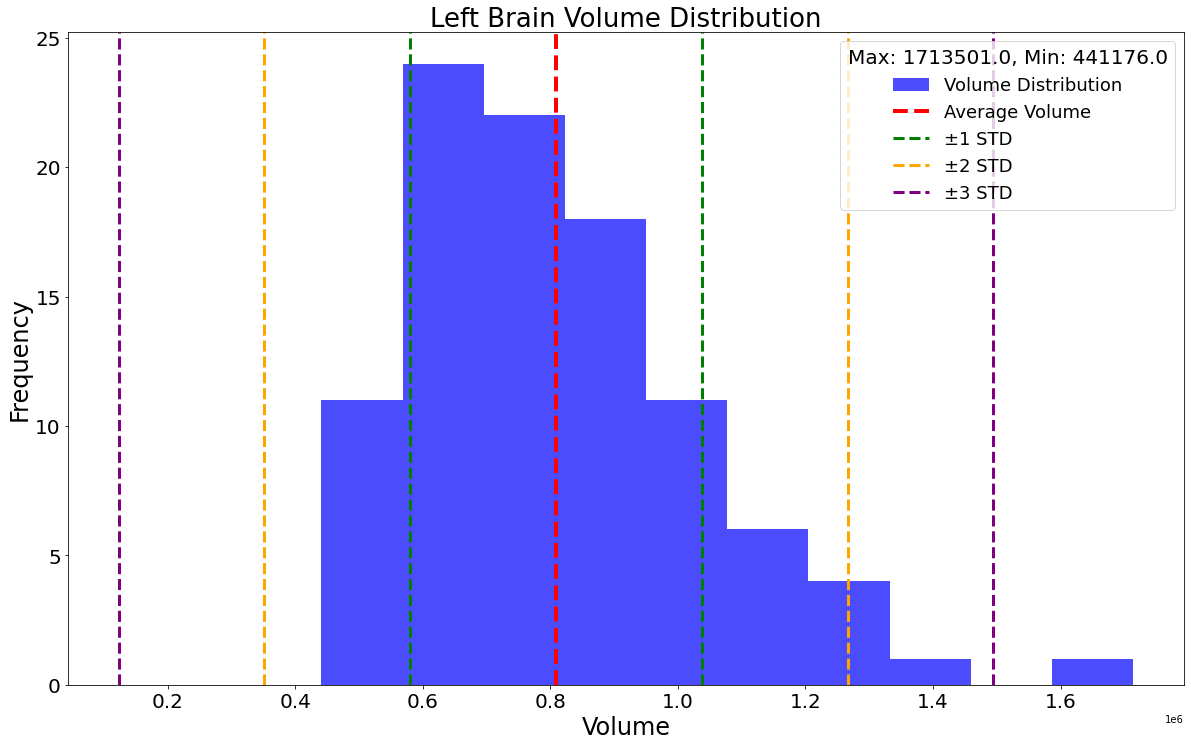

>>>>Left Brain<<<<
Average Volume: 808841.7142857143
Standard Deviation: 228522.56912803501
Maximum Volume: 1713501.0
Minimum Volume: 441176.0


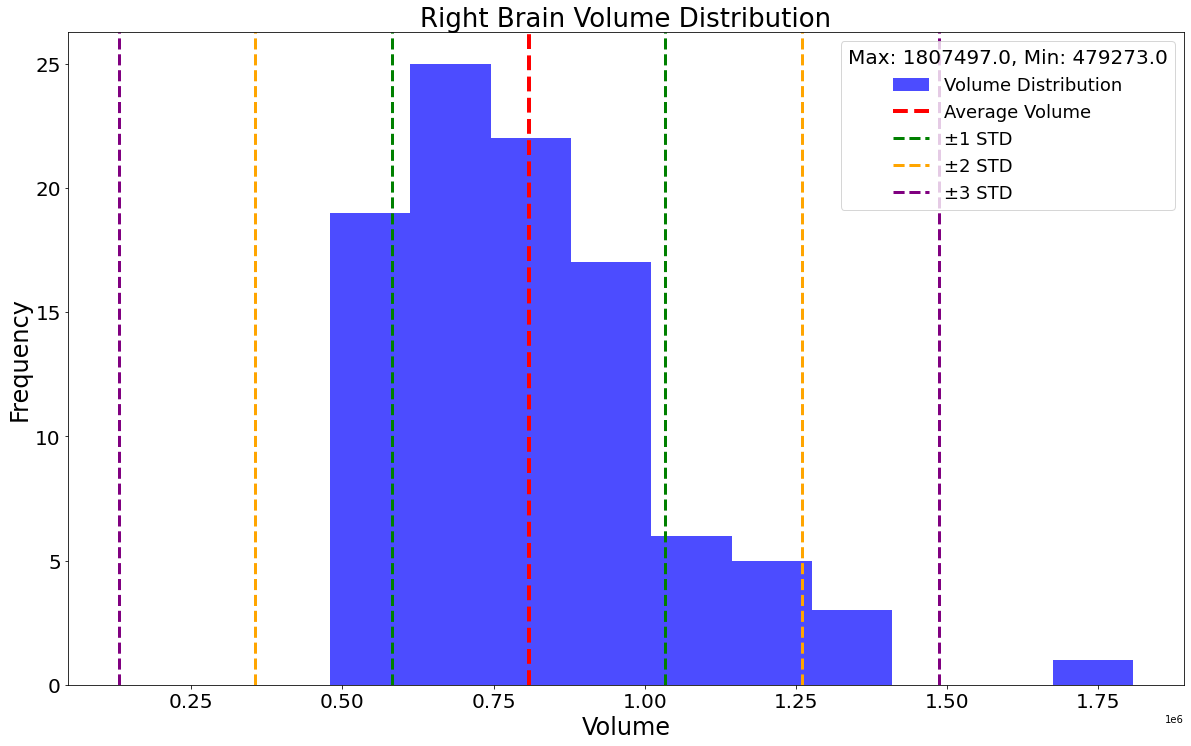

>>>>Right Brain<<<<
Average Volume: 807831.1428571428
Standard Deviation: 226059.48279375405
Maximum Volume: 1807497.0
Minimum Volume: 479273.0


In [83]:
# 這一步要繪製左腦、右腦體積分布圖(同時顯示最大值、平均值、標準差) 
# ====================先分析左腦====================

# 計算每個左腦的體積
left_volumes = df_filtered["Left Volume"]

# 計算統計數據
average_volume = np.mean(left_volumes)
std_dev = np.std(left_volumes)
max_volume = np.max(left_volumes)
min_volume = np.min(left_volumes)

# 繪製體積分布圖
plt.figure(figsize=(20, 12))
plt.hist(left_volumes, bins=10, color='blue', alpha=0.7, label='Volume Distribution')
plt.axvline(average_volume, color='r', linestyle='dashed', linewidth=4, label='Average Volume')
plt.axvline(average_volume - std_dev, color='g', linestyle='dashed', linewidth=3, label='±1 STD')
plt.axvline(average_volume + std_dev, color='g', linestyle='dashed', linewidth=3)
plt.axvline(average_volume - 2*std_dev, color='orange', linestyle='dashed', linewidth=3, label='±2 STD')
plt.axvline(average_volume + 2*std_dev, color='orange', linestyle='dashed', linewidth=3)
plt.axvline(average_volume - 3*std_dev, color='purple', linestyle='dashed', linewidth=3, label='±3 STD')
plt.axvline(average_volume + 3*std_dev, color='purple', linestyle='dashed', linewidth=3)

plt.title('Left Brain Volume Distribution',size=26)
plt.xlabel('Volume',size=24)
plt.ylabel('Frequency',size=24)
plt.xticks(fontsize=20)  # X轴刻度字体大小
plt.yticks(fontsize=20)  # Y轴刻度字体大小
plt.legend(title=f"Max: {max_volume}, Min: {min_volume}", title_fontsize='20', fontsize='18', loc='upper right')  # 将图例放置在右上方、文字大小
plt.show()

# 印出統計數據
print('>>>>Left Brain<<<<')
print(f"Average Volume: {average_volume}")
print(f"Standard Deviation: {std_dev}")
print(f"Maximum Volume: {max_volume}")
print(f"Minimum Volume: {min_volume}")
print('==================')
# ====================先分析右腦====================



# 計算每個右腦的體積
right_volumes = df_filtered["Right Volume"]

# 計算統計數據
average_volume = np.mean(right_volumes)
std_dev = np.std(right_volumes)
max_volume = np.max(right_volumes)
min_volume = np.min(right_volumes)

# 繪製體積分布圖
plt.figure(figsize=(20, 12))
plt.hist(right_volumes, bins=10, color='blue', alpha=0.7, label='Volume Distribution')
plt.axvline(average_volume, color='r', linestyle='dashed', linewidth=4, label='Average Volume')
plt.axvline(average_volume - std_dev, color='g', linestyle='dashed', linewidth=3, label='±1 STD')
plt.axvline(average_volume + std_dev, color='g', linestyle='dashed', linewidth=3)
plt.axvline(average_volume - 2*std_dev, color='orange', linestyle='dashed', linewidth=3, label='±2 STD')
plt.axvline(average_volume + 2*std_dev, color='orange', linestyle='dashed', linewidth=3)
plt.axvline(average_volume - 3*std_dev, color='purple', linestyle='dashed', linewidth=3, label='±3 STD')
plt.axvline(average_volume + 3*std_dev, color='purple', linestyle='dashed', linewidth=3)

plt.title('Right Brain Volume Distribution',size=26)
plt.xlabel('Volume',size=24)
plt.ylabel('Frequency',size=24)
plt.xticks(fontsize=20)  # X轴刻度字体大小
plt.yticks(fontsize=20)  # Y轴刻度字体大小
plt.legend(title=f"Max: {max_volume}, Min: {min_volume}", title_fontsize='20', fontsize='18', loc='upper right')  # 将图例放置在右上方、文字大小
plt.show()

# 印出統計數據
print('>>>>Right Brain<<<<')
print(f"Average Volume: {average_volume}")
print(f"Standard Deviation: {std_dev}")
print(f"Maximum Volume: {max_volume}")
print(f"Minimum Volume: {min_volume}")
print('==================')

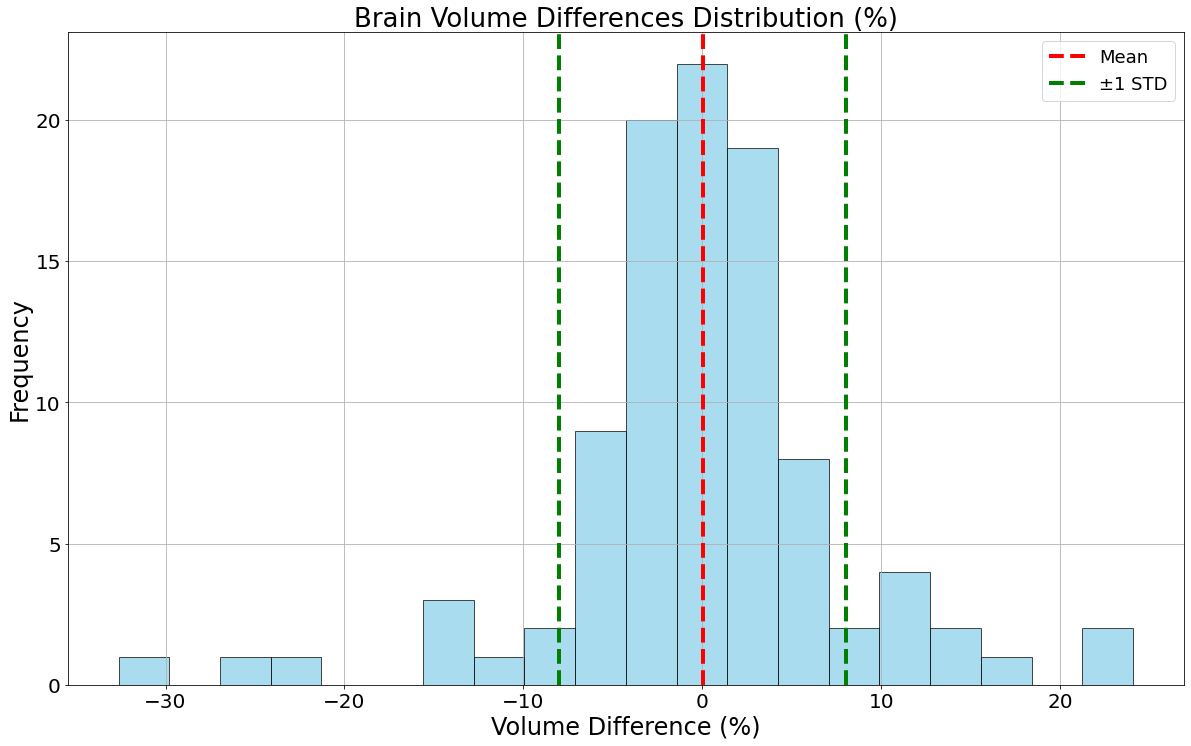

Number of cases where the left brain is larger: 48
Number of cases where the right brain is larger: 50
Mean Volume Difference (%): 0.025199486064965675
Standard Deviation: 8.013357408282056


In [78]:
import matplotlib.pyplot as plt

# 在計算左右腦體積平均值和標準差時先排除 npf-F-200006(左腦有預測錯誤) VGlut-F-500039(左右腦都有預測錯誤)


# 计算百分比差异的平均值和标准差
mean_difference = np.mean(df_filtered["Percentage Difference (%)"])
std_deviation = np.std(df_filtered["Percentage Difference (%)"])

# 绘制体积差异百分比的分布图
plt.figure(figsize=(20, 12))
plt.hist(df_filtered["Percentage Difference (%)"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_difference, color='r', linestyle='dashed', linewidth=4, label='Mean')
plt.axvline(mean_difference - std_deviation, color='g', linestyle='dashed', linewidth=4, label='±1 STD')
plt.axvline(mean_difference + std_deviation, color='g', linestyle='dashed', linewidth=4)

plt.title('Brain Volume Differences Distribution (%)',size=26)
plt.xlabel('Volume Difference (%)',size=24)
plt.ylabel('Frequency',size=24)
plt.xticks(fontsize=20)  # X轴刻度字体大小
plt.yticks(fontsize=20)  # Y轴刻度字体大小
plt.grid(True)
plt.legend(fontsize='18')

# 显示图表
plt.show()

# 计算左脑体积大（即百分比差异<0）和右脑体积大（即百分比差异>0）的数量
left_larger = sum(diff < 0 for diff in df_filtered["Percentage Difference (%)"])
right_larger = sum(diff > 0 for diff in df_filtered["Percentage Difference (%)"])

print(f"Number of cases where the left brain is larger: {left_larger}")
print(f"Number of cases where the right brain is larger: {right_larger}")

# 打印平均值和标准差
print(f"Mean Volume Difference (%): {mean_difference}")
print(f"Standard Deviation: {std_deviation}")

In [81]:
# 筛选 Percentage Difference (%) < -20 的行
df_filtered_negative = df_filtered[df_filtered['Percentage Difference (%)'] < -20]

df_filtered_negative

,Brain ID,Left Volume,Right Volume,Average Volume,Volume Difference,Percentage Difference (%)
6,Cha-F-200191,1275118.0,1011142.0,1143130.0,-263976.0,-23.092387
16,E0585-F-100016,956787.0,746307.0,851547.0,-210480.0,-24.717367
17,E0585-F-100030,1050985.0,756176.0,903580.5,-294809.0,-32.626755


(118, 362, 362)


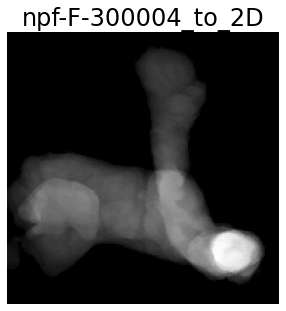

[['5HT1A-F-600003_No_1_DLG', 170, 560, 19, 409, 127, 45],
 ['5HT1A-F-600003_No_2_DLG', 513, 894, 40, 421, 127, 45],
 ['5HT1A-F-700024_No_1_DLG', 477, 839, 73, 435, 118, 36],
 ['5HT1A-F-700024_No_2_DLG', 139, 506, 68, 435, 118, 36]]

In [316]:

# 投影成2D圖
input_dir = Step4_output_path
reconstructed = np.load(os.path.join(input_dir, "5HT1A-F-700024_No_1_DLG_reconstructed.npy"))
print(reconstructed.shape)
projection = np.sum(reconstructed, axis=0)  # 取加總值
# 顯示2D圖像
plt.figure(figsize=(5, 5))
plt.imshow(projection, cmap='gray')
plt.title(brain_file + '_to_2D', fontsize=24)
plt.axis('off')
plt.show()
original_info[:4]